## **Step 1: Loading and Processing the Data**

In [5]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [6]:
# Path to dataset
dataset_path = "fashion"

# Get list of categories
categories = os.listdir(dataset_path)
print("Categories:", categories)

# Prepare storage for images and labels
image_data = []
labels = []

# Set image size for consistency
image_size = (28, 28)

Categories: ['ankleboot', 'bag', 'coat', 'dress', 'pullover', 'sandal', 'shirt', 'sneaker', 'trouser', 'tshirt-top']


In [7]:
# Load images and store first 5 images for visualization
sample_images = {category: [] for category in categories}

for label, category in enumerate(categories):
    category_path = os.path.join(dataset_path, category)
    # Track number of images processed per category
    count = 0 
    
    for image_name in os.listdir(category_path):
        image_path = os.path.join(category_path, image_name)

        # Open, resize, and convert image to grayscale
        img = Image.open(image_path).convert("L")
        img = img.resize(image_size)
        # Flatten image into 1D array
        img_array = np.array(img).flatten()  

        # Store the image data and corresponding label
        image_data.append(img_array)
        labels.append(label)

        # Store sample images (only first 5 per category)
        if count < 5:
            sample_images[category].append(np.array(img))  # Store raw image for display
            count += 1

In [8]:
# Convert to NumPy arrays
X = np.array(image_data)
y = np.array(labels)

# Tests
print(f"Number of images and pixel size: {X.shape}")
print(f"Number of labels: {y.shape}")
print(f"Number of catagories: {len(categories)}")

Number of images and pixel size: (70000, 784)
Number of labels: (70000,)
Number of catagories: 10


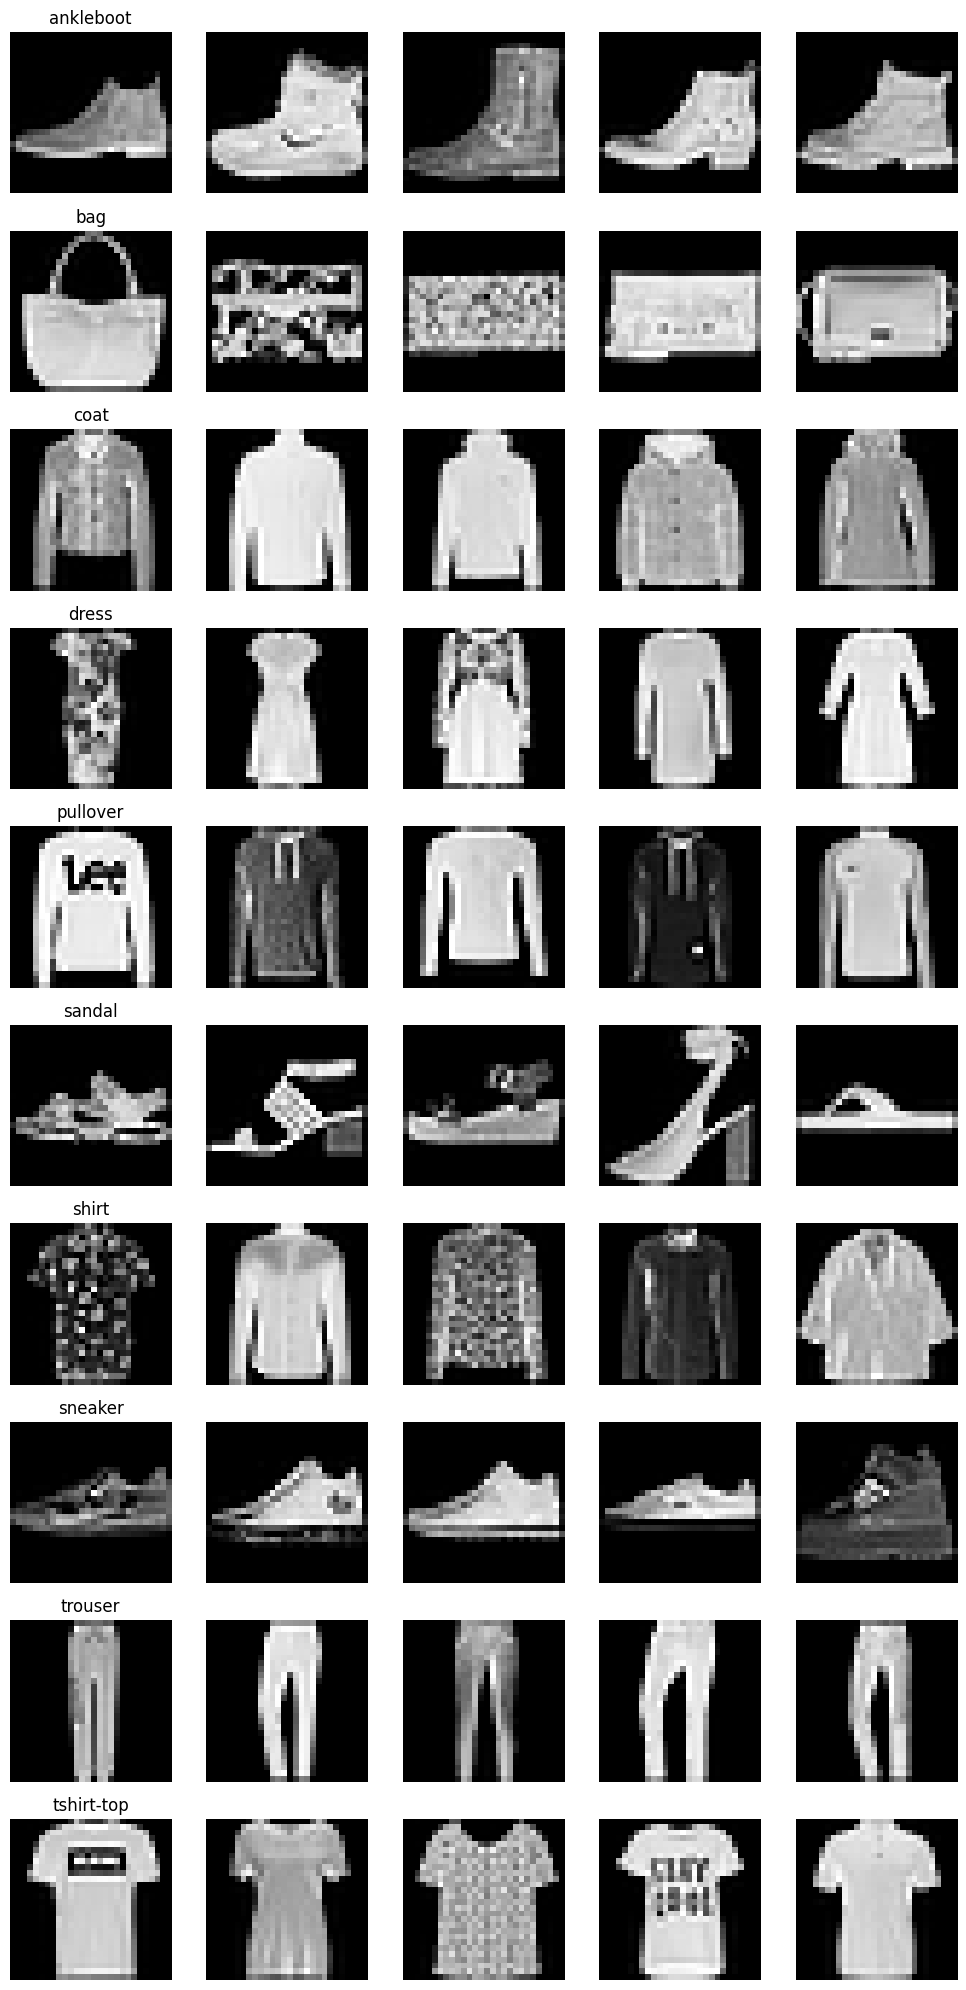

In [9]:
# Display sample images (5 per category)
fig, axes = plt.subplots(len(categories), 5, figsize=(10, len(categories) * 2))

for row, category in enumerate(categories):
    for col in range(5):
        if col < len(sample_images[category]):
            axes[row, col].imshow(sample_images[category][col], cmap="gray")
            axes[row, col].axis("off")
            axes[row, col].set_title(category if col == 0 else "")

plt.tight_layout()
plt.show()

## **Step 2: Normalising the Data**

In [10]:
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [11]:
# Normalise pixel values to range [0, 1]
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [12]:
print(f"Min pixel value after scaling: {X.min()}")
print(f"Max pixel value after scaling: {X.max()}")
print(f"Min pixel value after scaling: {X_scaled.min()}")
print(f"Max pixel value after scaling: {X_scaled.max()}")
print("Data normalized successfully!")

Min pixel value after scaling: 0
Max pixel value after scaling: 255
Min pixel value after scaling: 0.0
Max pixel value after scaling: 1.0
Data normalized successfully!


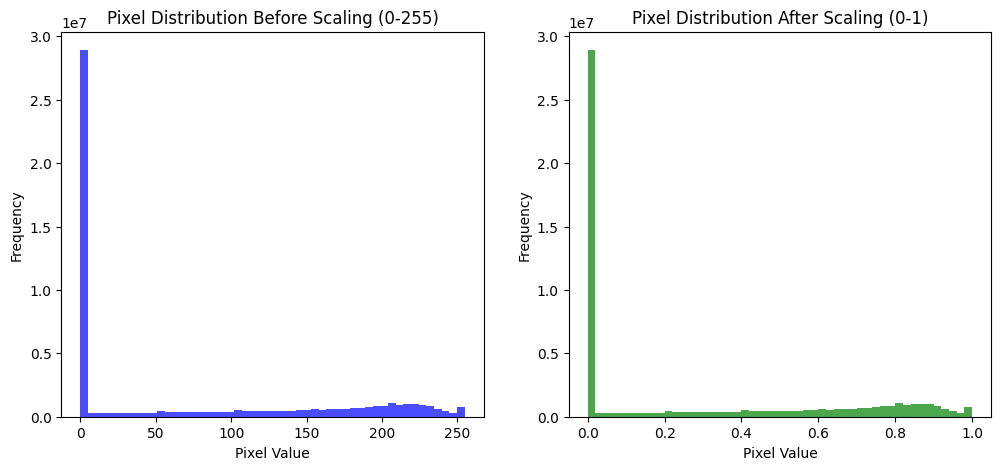

In [13]:
plt.figure(figsize=(12, 5))

# Histogram before scaling
plt.subplot(1, 2, 1)
plt.hist(X.flatten(), bins=50, color='blue', alpha=0.7)
plt.title("Pixel Distribution Before Scaling (0-255)")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")

# Histogram after scaling
plt.subplot(1, 2, 2)
plt.hist(X_scaled.flatten(), bins=50, color='green', alpha=0.7)
plt.title("Pixel Distribution After Scaling (0-1)")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")

plt.show()


## **Step 4. Spliting Data into Training and Testing Sets**

In [14]:
from sklearn.model_selection import train_test_split

In [15]:
# Use Student ID G00409920 (without G and leading 0s) as random seed
student_id = 409920
np.random.seed(student_id)

# Split dataset into train (70%), other (30%)
X_train, X_other, y_train, y_other = train_test_split(
    X_scaled, y, test_size=0.3, stratify=y, random_state=student_id
)

# Split other into validation (15%) and test (15%)
X_valid, X_test, y_valid, y_test = train_test_split(
    X_other, y_other, test_size=0.5, stratify=y_other, random_state=student_id
)

In [16]:
# Print the dataset sizes
print(f"Training set: {len(X_train)} samples")
print(f"Validation set: {len(X_valid)} samples")
print(f"Test set: {len(X_test)} samples")

Training set: 49000 samples
Validation set: 10500 samples
Test set: 10500 samples


## **Step 5: Training the Models**

### Training and Evaluating SVM

In [32]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt

In [33]:
# Train SVM with linear kernel
svm_model = SVC(kernel="linear", class_weight="balanced", random_state=student_id)

# Define K-Fold with shuffling
cv = KFold(n_splits=5, shuffle=True, random_state=student_id)

# Perform 5-fold cross-validation with shuffling
svm_scores = cross_val_score(svm_model, X_train, y_train, cv=cv)

# Print performance for each fold
print("SVM Cross-Validation Results (5 folds):")
for fold_index, score in enumerate(svm_scores, start=1):
    print(f" Fold {fold_index} Accuracy: {score:.4f}")

# Print average and standard deviation
print(f"\nMean Accuracy: {svm_scores.mean():.4f} ± {svm_scores.std():.4f}")


SVM Cross-Validation Results (5 folds):
 Fold 1 Accuracy: 0.8510
 Fold 2 Accuracy: 0.8574
 Fold 3 Accuracy: 0.8512
 Fold 4 Accuracy: 0.8512
 Fold 5 Accuracy: 0.8534

Mean Accuracy: 0.8529 ± 0.0025


In [19]:
# Train on full training set
svm_model.fit(X_train, y_train)

# Evaluate on validation set
y_valid_pred = svm_model.predict(X_valid)
svm_valid_accuracy = accuracy_score(y_valid, y_valid_pred)

print(f"SVM Validation Accuracy: {svm_valid_accuracy:.4f}")


SVM Validation Accuracy: 0.8623


In [20]:
# Evaluate on the test set (unseen data)
y_test_pred = svm_model.predict(X_test)
svm_test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"SVM Test Accuracy: {svm_test_accuracy:.4f}")

SVM Test Accuracy: 0.8550


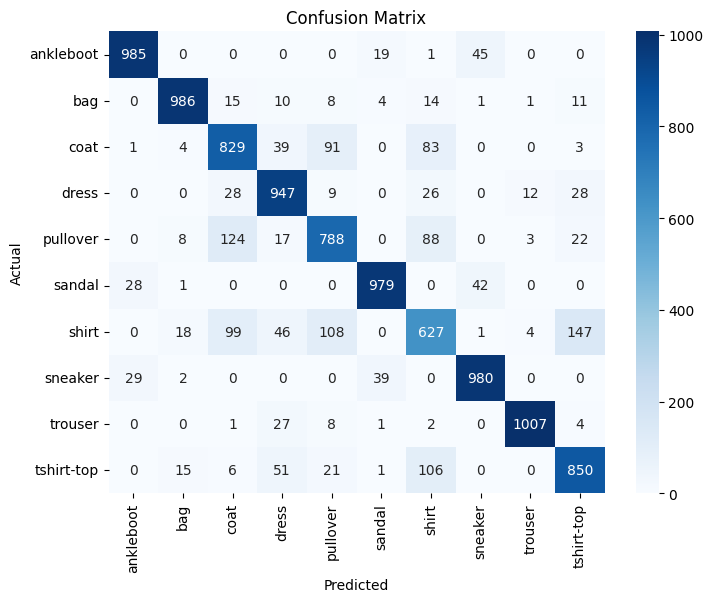

In [21]:
cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=categories, yticklabels=categories)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [22]:
print("Classification Report:")
print(classification_report(y_test, y_test_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94      1050
           1       0.95      0.94      0.95      1050
           2       0.75      0.79      0.77      1050
           3       0.83      0.90      0.87      1050
           4       0.76      0.75      0.76      1050
           5       0.94      0.93      0.94      1050
           6       0.66      0.60      0.63      1050
           7       0.92      0.93      0.92      1050
           8       0.98      0.96      0.97      1050
           9       0.80      0.81      0.80      1050

    accuracy                           0.86     10500
   macro avg       0.85      0.86      0.85     10500
weighted avg       0.85      0.86      0.85     10500



### Training and Evaluating KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

In [39]:
# Define K-Fold with shuffling
cv = KFold(n_splits=5, shuffle=True, random_state=student_id)

# Define range of k values to test
k_values = list(range(1, 16))

# Store mean accuracy for each k
mean_accuracies = []

# Perform 5-fold cross-validation for each k
for k in k_values:
    knn_model = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn_model, X_train, y_train, cv=cv)
    mean_accuracy = scores.mean()
    mean_accuracies.append(mean_accuracy)
    print(f"k={k}, Mean Accuracy: {mean_accuracy:.4f}")

k=1, Mean Accuracy: 0.8429
k=2, Mean Accuracy: 0.8380
k=3, Mean Accuracy: 0.8479
k=4, Mean Accuracy: 0.8482
k=5, Mean Accuracy: 0.8507
k=6, Mean Accuracy: 0.8508
k=7, Mean Accuracy: 0.8495
k=8, Mean Accuracy: 0.8497
k=9, Mean Accuracy: 0.8479
k=10, Mean Accuracy: 0.8471
k=11, Mean Accuracy: 0.8461
k=12, Mean Accuracy: 0.8459
k=13, Mean Accuracy: 0.8438
k=14, Mean Accuracy: 0.8445
k=15, Mean Accuracy: 0.8431


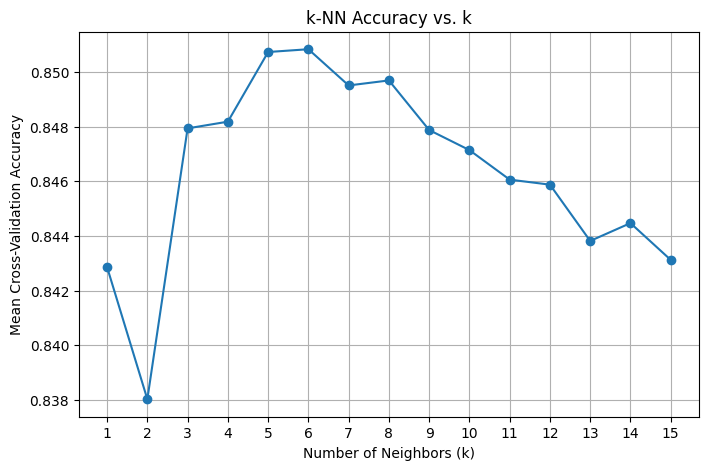


Best k based on cross-validation: 6


In [40]:
# Plot accuracy vs k
plt.figure(figsize=(8, 5))
plt.plot(k_values, mean_accuracies, marker='o', linestyle='-')
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Mean Cross-Validation Accuracy")
plt.title("k-NN Accuracy vs. k")
plt.xticks(k_values)
plt.grid(True)
plt.show()

# Best k value based on highest accuracy
best_k = k_values[np.argmax(mean_accuracies)]
print(f"\nBest k based on cross-validation: {best_k}")

In [41]:
# Train final KNN model using best k
knn_model = KNeighborsClassifier(n_neighbors=best_k)
knn_model.fit(X_train, y_train)

# Evaluate on validation set
y_valid_pred = knn_model.predict(X_valid)
knn_valid_accuracy = accuracy_score(y_valid, y_valid_pred)

print(f"KNN Validation Accuracy: {knn_valid_accuracy:.4f}")

KNN Validation Accuracy: 0.8544
